In [17]:
from ipyparallel import Client

rc = Client()

dview = rc[:]
lbview = rc.load_balanced_view()

print("Connected to %d workers: %s" % (len(rc.ids), rc.ids))

Connected to 16 workers: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20, 22, 23]


In [48]:
#%%px --local
from scipy.special import legendre
import numpy as np
from numpy.polynomial.legendre import Legendre
import numpy.polynomial.polynomial as poly
from numpy.random import normal, uniform, seed
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.metrics import mean_squared_error
%matplotlib notebook

### Criando polinômios de Legendre:
1. Sorteia-se a partir de uma distribuição normal os coeficientes do polinômio.
+ Cria-se o polinômio f = a0 * L0 + a1 * L1 + ... + aq * Lq.
+ Calcula-se o valor esperado de f² (E[f²]). 
+ Reescala-se os coeficientes para que o E[f²] = 1. a0_rescaled = a0/sqrt(E[f²])

In [2]:
#%%px --local
def create_legendre_sigma(q):
    """ Create scaled legendre polynomial of order q """
    # Create q+1 coefficients
    coeffs = normal(size=q+1) 
    # Create Qth order Legendre polynomial combination
    leg_pol = Legendre(coeffs)
    
    # Get expected value of Legendre polynomial in a uniform distribution varying from -1 to 1
    # exp_val = stats.uniform.expect(lambda x: (leg_pol ** 2)(x), loc=-1, scale=2)
    # x = np.linspace(-1,1,10000)
    # exp_val = (leg_pol ** 2)(x).mean()
    exp_val = 0
    for i in range(0,len(coeffs),2):
        coeff_temp = [0]*len(coeffs)
        coeff_temp[i] = coeffs[i]
        try:
            coeff_temp[i+1] = coeffs[i+1]
        except IndexError:
            pass
        # Create Qth order Legendre polynomial combination
        leg_pol_temp = Legendre(coeff_temp)
        leg_integ = leg_pol_temp.integ()
        coeffs_sum = np.insert(coeff_temp, 0, 0)
        exp_val += np.multiply(coeffs_sum, leg_integ.coef).sum()
    
    # Rescale coefficients and recreate Legendre
    rescaled_coeffs = coeffs/np.sqrt(exp_val)
    rescaled_leg = Legendre(rescaled_coeffs)
    
    ####### EXTRA #######
    # Check if E[f²] = 1
    #print(stats.uniform.expect(lambda x: (rescaled_leg ** 2)(x), loc=-1, scale=2))
    #####################

    return rescaled_leg

### Calculando Eout
Dado um polinômio de Legendre de ordem q f(x), N pontos e a ordem h do polinômio da solução
1. Estima-se uma solução de ordem h para o polinômio hq
+ Calcula-se o Eout com o valor esperado: E[(hq(x) - f(x) - sigma*epsilon)²]

In [94]:
#%%px --local
def get_eout_sigma(f, h, x_in, f_noise):
    y = f(x_in) + f_noise
    x_in2 = np.linspace(-1,1,1000)
    y2 = f(x_in2)
    #hq = np.polyfit(x_in, y, h)
    hq = poly.polyfit(x_in, y, h)
    #eout = stats.uniform.expect(lambda x: (np.polyval(hq, x)-f(x))**2, loc=-1, scale=2)
    eout = stats.uniform.expect(lambda x: (poly.polyval(x, hq)-f(x))**2, loc=-1, scale=2)
    
    ####### EXTRA #######
    # Empirical Eout
    #x_out = np.linspace(-1,1,100000)
    #y_out = f(x_out)
    #y_hq_in = np.polyval(hq, x_in)
    y_hq_in = poly.polyval(x_in, hq)
    #y_hq_out = np.polyval(hq, x_out)
    #y_hq_out = poly.polyval(x_out, hq)
    #error_insample = mean_squared_error(y, y_hq_in)
    #error_outofsample = mean_squared_error(y_out, y_hq_out)

    # Plot functions
    plt.plot(x_in2, y2, label="Polinômio de ordem 15")
    plt.scatter(x_in, y, label="Observações com ruído de var 0.126")
    plt.xlim(-1, 1)
    #plt.plot(y_hq_in)
    plt.legend()
    plt.show()
    
    # Print errors
    #print("Analytic %f" % eout)
    #print("In Sample %f" % error_insample)
    #print("Out of Sample Experimental %f" % error_outofsample)
    #####################
    
    return eout

### Paralelizando
Para cada número de pontos n:
1. Para cada complexidade q:
  1. Para cada experimento k:
    1. Cria-se um polinômio de Legendre de ordem q f(x).
    + Cria-se N pontos para serem avaliados nesse polinômio: y = f(x) + sigma*epsilon
    + Calcula-se o Eout para hipóteses de ordem 2 e 10
  + Calcula-se a média dos Eouts
  + Calcula-se a diferença entre os Eouts, essa será a medida de Overfitting

In [37]:
#%%px --local
EXPERIMENT = 1
Q = 1
N_MAX = 130
#Q_MAX = 100
SIGMA_MAX = 2.5
SIGMA_MAX_IDX = 100
SIGMA_VAL = np.linspace(0.0001, SIGMA_MAX, SIGMA_MAX_IDX)
N_START = 50
NAME_SIGMA = "data_sigma_normal_TESTE_%d+%d_%d_%d_%d" %(N_MAX, N_START, SIGMA_MAX, Q, EXPERIMENT)
NAME_SIGMA_PNG = NAME_SIGMA + '.png'
NAME_SIGMA_PKL = NAME_SIGMA + '.pkl'
NAME_SIGMA_RUN = NAME_SIGMA + 'times_run.pkl'
print(NAME_SIGMA_PKL)

data_sigma_normal_TESTE_130+50_2_1_1.pkl


In [76]:
#%%px --local
def create_plot_sigma(sigma_idx, q, n, k, seed_init):
    seed(seed_init)
    f = create_legendre_sigma(q+1)
    #print("SIGMA %s" % SIGMA_VAL[sigma_idx])
    print(SIGMA_VAL[sigma_idx])
    f_noise = normal(0, np.sqrt(SIGMA_VAL[sigma_idx]), size=n+1)
    #print("F NOISE %s" % f_noise)
    #print("F %s" % f)
    x_in = uniform(-1,1,n+1)
    x_in.sort()
    #x_in = np.linspace(-1,1,80)
    eout2 = get_eout_sigma(f, 2, x_in, f_noise)
    #eout10 = get_eout_sigma(f, 10, x_in, f_noise)
    eout10 =2 
    return (sigma_idx, n, q, eout10, eout2)

In [10]:
import pickle

In [8]:
#plot_array = np.zeros((N_MAX-N_START+1,SIGMA_MAX_IDX))
#times_run = np.zeros((N_MAX-N_START+1,SIGMA_MAX_IDX))

#idx = 1

In [11]:
with open(NAME_SIGMA_PKL, 'rb') as pickle_file:
    plot_array = pickle.load(pickle_file)
with open(NAME_SIGMA_RUN, 'rb') as pickle_file:
    times_run = pickle.load(pickle_file)

In [25]:
times_run_nozero = np.transpose(np.nonzero(times_run))
print("Total distinct index: %d" % len(times_run_nozero))
max_times = np.amax(times_run)
min_times = np.amin(times_run)
print("Max number of times: %d" % max_times)
print("Min number of times: %d" % min_times)
idx = np.where( times_run == max_times )
idx = zip(*idx)
for item in idx:
    print("At position: %s - %d" % (item, times_run[item[0], item[1]]))
    
print("Total de vezes rodado: %d" % times_run.sum())

#for element in np.transpose(np.nonzero(times_run)):
#    print("%s - %d" %(element, times_run[element[0], element[1]]))

Total distinct index: 8100
Max number of times: 5793
Min number of times: 5218
At position: (37, 22) - 5793
Total de vezes rodado: 44733200


In [7]:
idx = 1

In [27]:
#N_START = 60

Running for 118th time
0.126357575758


<IPython.core.display.Javascript object>


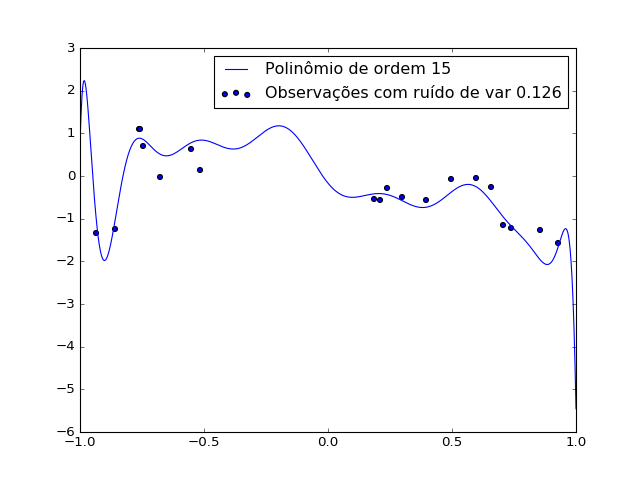

[(5, 20, 15, 2, 0.4242004710436599)]
Sigma: 5
N: 20
error_diff: 1.57579952895634


In [107]:
#%%time
# Just keep it running

while True:
    print("Running for %dth time" % idx)
    idx += 1
    #result_time = []
    # Complexity is fixed for this problem
    q = Q
    # Iterate noise
    sigma_idx = uniform(0, 100, EXPERIMENT).astype(int)
    # Iterate datapoints
    n = uniform(N_START, N_MAX+1, EXPERIMENT).astype(int)
    #Iterate experiments
    #async_result = lbview.map_async(
    #    create_plot_sigma,
    #    sigma_idx,
    #    [q]*EXPERIMENT,
    #      n,
    #    range(0,EXPERIMENT),
    #    uniform(0,(2**32)-1, EXPERIMENT).astype(int),
    #)
    #async_result.wait_interactive()
    #print("Speedup: %.2f x" % (1.0 * async_result.serial_time / async_result.wall_time))
    #result_time = async_result.wall_time
    async_result = []
    seed_init = uniform(0,(2**32)-1, EXPERIMENT).astype(int)
    for i,d in enumerate(n):
        async_result.append(create_plot_sigma(5, 15, 20, i, seed_init[i]))
    
    print(async_result)
    for item in async_result:
        sigma_idx = item[0]
        n = item[1]
        #q = item[2]
        error_diff = item[3] - item[4]
        print("Sigma:", sigma_idx)
        print("N:", n)
        print("error_diff:", error_diff)
        #plot_array[n-N_START,sigma_idx] = (plot_array[n-N_START,sigma_idx] * times_run[
                #n-N_START,sigma_idx] + error_diff)/(times_run[n-N_START,sigma_idx]+1)
        #times_run[n-N_START,sigma_idx] += 1
           
    #print("Round %d took %.2f seconds" % (idx, async_result.wall_time))
    #with open(NAME_SIGMA_PKL, 'wb') as pickle_file:
    #    pickle.dump(plot_array, pickle_file)
    #with open(NAME_SIGMA_RUN, 'wb') as pickle_file:
    #    pickle.dump(times_run, pickle_file)
    break

In [61]:
SIGMA_VAL[5]

0.12635757575757572

### PROBLEMAS 
